# Search: Solving a Maze Using a Goal-based Agent

Student Name: Christian Melendez

I have used the following AI tools: None

I understand that my submission needs to be my own work: CM

## Instructions

Total Points: Undergrads 100 + 5 bonus / Graduate students 110

Complete this notebook. Use the provided notebook cells and insert additional code and markdown cells as needed. Submit the completely rendered notebook as a HTML file.


## Introduction

The agent has a map of the maze it is in and the environment is assumed to be **deterministic, discrete, and known.** The agent must use the map to plan a path through the maze from the starting location $S$ to the goal location $G$.  This is a planing exercise for a goal-based agent, so you do not need to implement an environment, just use the map to search for a path. Once the plan is made, the agent in a deterministic environment (i.e., the transition function is deterministic with the outcome of each state/action pair fixed and no randomness) can just follow the path and does not need to care about the percepts.
This is also called an **[open-loop system](https://en.wikipedia.org/wiki/Open-loop_controller).**
The execution phase is trivial and we do not implement it in this exercise.

Tree search algorithm implementations that you find online and used in general algorithms courses have often a different aim. These algorithms assume that you already have a tree in memory. We are interested in dynamically creating a search tree with the aim of finding a good/the best path from the root noteto the goal state. Follow the pseudo code presented in the text book (and replicated in the slides) closely. Ideally, we would like to search only a small part of the maze, i.e., create a search tree with as few nodes as possible.

Several mazes for this exercise are stored as text files. Here is the small example maze:

In [1]:
with open("mazes/small_maze.txt", "r") as f:
    maze_str = f.read()
print(maze_str)

XXXXXXXXXXXXXXXXXXXXXX
X XX        X X      X
X    XXXXXX X XXXXXX X
XXXXXX     S  X      X
X    X XXXXXX XX XXXXX
X XXXX X         X   X
X        XXX XXX   X X
XXXXXXXXXX    XXXXXX X
XG         XX        X
XXXXXXXXXXXXXXXXXXXXXX


__Note:__ The mazes above contains cycles and therefore the state space may not form proper trees unless cycles are prevented. Therfore, you will need to deal with cycle detection in your code.

## Parsing and pretty printing the maze

The maze can also be displayed in color using code in the module [maze_helper.py](maze_helper.py). The code parses the string representing the maze and converts it into a `numpy` 2d array which you can use in your implementation. Position are represented as a 2-tuple of the form `(row, col)`.

In [2]:
import maze_helper as mh

maze = mh.parse_maze(maze_str)

# look at a position in the maze by subsetting the 2d array
print("Position(0,0):", maze[0, 0])

# there is also a helper function called `look(maze, pos)` available
# which uses a 2-tuple for the position.
print("Position(8,1):", mh.look(maze, (8, 1)))

Position(0,0): X
Position(8,1): G


A helper function to visualize the maze is also available.

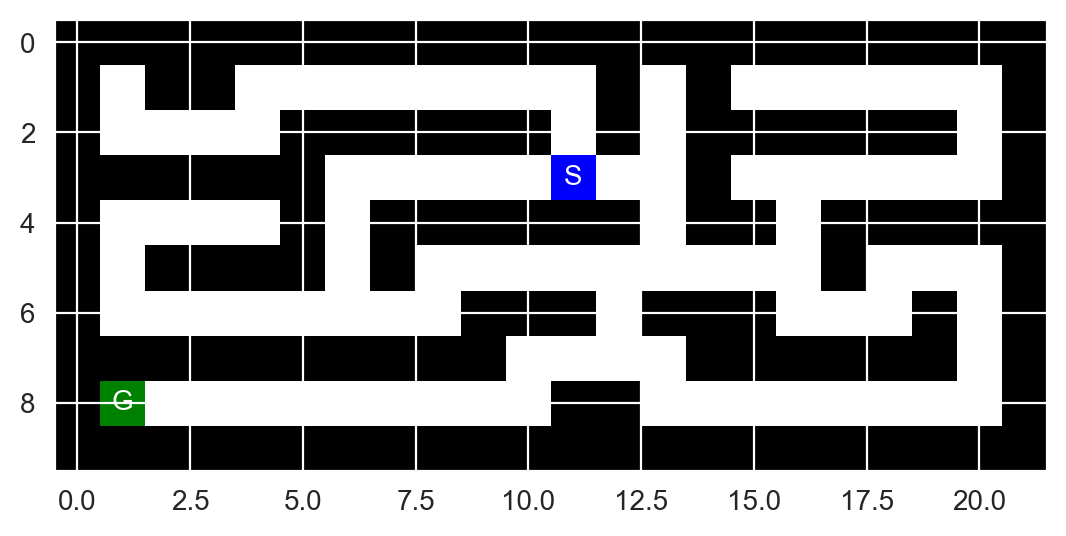

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# use higher resolution images in notebook

mh.show_maze(maze)

Find the position of the start and the goal using the helper function `find_pos()`

In [4]:
print("Start location:", mh.find_pos(maze, what = "S"))
print("Goal location:", mh.find_pos(maze, what = "G"))

Start location: (3, 11)
Goal location: (8, 1)


Helper function documentation.

In [5]:
help(mh)

Help on module maze_helper:

NAME
    maze_helper

DESCRIPTION
    Code for the Maze Assignment by Michael Hahsler
    Usage: 
        import maze_helper as mh
        mh.show_some_mazes()

FUNCTIONS
    find_pos(maze, what='S')
        Find start/goal in a maze and returns the first one. 
        Caution: there is no error checking!
        
        Parameters:
        maze: a array with characters prodced by parse_maze()
        what: the letter to be found ('S' for start and 'G' for goal)
        
        Returns:
        a tupple (x, y) for the found position.
    
    look(maze, pos)
        Look at the label of a square with the position as an array of the form (x, y).
    
    parse_maze(maze_str)
        Convert a maze as a string into a 2d numpy array
    
    show_maze(maze, fontsize=10)
        Display a (parsed) maze as an image.
    
    welcome()
        Welcome message.

FILE
    c:\users\bola\documents\smu\spring 2024\cs7320 - artificial intelligence\maze_helper.py


## Tree structure

Here is an implementation of the basic node structure for the search algorithms (see Fig 3.7 on page 73). I have added a method that extracts the path from the root node to the current node. It can be used to get the path when the search is completed.

In [6]:
class Node:
    def __init__(self, pos, parent, action, cost):
        self.pos = tuple(pos)    # the state; positions are (row,col)
        self.parent = parent     # reference to parent node. None means root node.
        self.action = action     # action used in the transition function (root node has None)
        self.cost = cost         # for uniform cost this is the depth. It is also g(n) for A* search
        self.dist = 0            # used to sort manhattan distance later, for a* it will be the cost + manhattan distance

    def __str__(self):
        return f"Node - pos = {self.pos}; action = {self.action}; cost = {self.cost}"

    def get_path_from_root(self):
        """returns nodes on the path from the root to the current node."""
        node = self
        path = [node]

        while not node.parent is None:
            node = node.parent
            path.append(node)

        path.reverse()

        return(path)
    
    # I added the expand function to help with my search algorithms. It's straightforward, look in the 4 directions and expand if it's not an X.
    def expand(self, maze):
        node_list = []
        if mh.look(maze, (self.pos[0] - 1 ,self.pos[1])) != 'X':
            north_node = Node(pos=(self.pos[0] - 1 ,self.pos[1]),parent=self, action='North', cost=self.cost + 1)
            node_list.append(north_node)
        if mh.look(maze, (self.pos[0] + 1 ,self.pos[1])) != 'X':
            south_node = Node(pos=(self.pos[0] + 1 ,self.pos[1]),parent=self, action='South', cost=self.cost + 1)
            node_list.append(south_node)
        if mh.look(maze, (self.pos[0] ,self.pos[1] - 1)) != 'X':
            west_node = Node(pos=(self.pos[0] ,self.pos[1] - 1),parent=self, action='West', cost=self.cost + 1)
            node_list.append(west_node)   
        if mh.look(maze, (self.pos[0] ,self.pos[1] + 1)) != 'X':
            east_node = Node(pos=(self.pos[0] ,self.pos[1] + 1),parent=self, action='East', cost=self.cost + 1)
            node_list.append(east_node)    
        return node_list

If needed, then you can add more fields to the class like the heuristic value $h(n)$ or $f(n)$.

Examples for how to create and use a tree and information on memory management can be found [here](../HOWTOs/trees.ipynb).

# Tasks

The goal is to:

1. Implement the following search algorithms for solving different mazes:

    - Breadth-first search (BFS)
    - Depth-first search (DFS)
    - Greedy best-first search (GBFS)
    - A* search

2. Run each of the above algorithms on the
    - [small maze](small_maze.txt),
    - [medium maze](medium_maze.txt),
    - [large maze](large_maze.txt),
    - [open maze](open_maze.txt),
    - [wall maze](wall_maze.txt),
    - [loops maze](loops_maze.txt),
    - [empty maze](empty_maze.txt), and
    - [empty 2_maze](empty_2_maze.txt).
    
3. For each problem instance and each search algorithm, report the following in a table:

    - The solution and its path cost
    - Total number of nodes expanded
    - Maximum tree depth
    - Maximum size of the frontier

4. Display each solution by marking every maze square (or state) visited and the squares on the final path.

## General [10 Points]

1. Make sure that you use the latest version of this notebook. Sync your forked repository and pull the latest revision.
2. Your implementation can use libraries like math, numpy, scipy, but not libraries that implement inteligent agents or complete search algorithms. Try to keep the code simple! In this course, we want to learn about the algorithms and we often do not need to use object-oriented design.
3. You notebook needs to be formated professionally.
    - Add additional markdown blocks for your description, comments in the code, add tables and use mathplotlib to produce charts where appropriate
    - Do not show debugging output or include an excessive amount of output.
    - Check that your PDF file is readable. For example, long lines are cut off in the PDF file. You don't have control over page breaks, so do not worry about these.
4. Document your code. Add a short discussion of how your implementation works and your design choices.

## Task 1: Defining the search problem and determining the problem size [10 Points]

Define the components of the search problem:

* Initial state
* Actions
* Transition model
* Goal state
* Path cost

Use verbal descriptions, variables and equations as appropriate.

*Note:* You can swich the next block from code to Markdown and use formatting.

Initial State : The initial state is the starting and goal location along with the walls and paths of the maze.
Actions : Move North, South, East, West.
Transition Model : A function of the current state and action and the resulting state. In this case It is T(state, action) = new_state where state and new_state are positions.
Goal State : The goal state is the user reaching the 'G' on the maze with a minimalized path cost.
Path Cost : The path cost is the number of spaces walked through to reach the goal.

Give some estimates for the problem size:

* $n$: state space size
* $d$: depth of the optimal solution
* $m$: maximum depth of tree
* $b$: maximum branching factor

Describe how you would determin these values for a given maze.

State space size : This is equal to |v| + |e| where v = all the nodes (available spaces for the agent to be including start and goal spaces) and e is all the distinct state/action pairs. Therefore, our state space size is roughly 5 * the number of available spaces.
Depth of the optimal solution : This is equal to the path cost.
Maximum depth of tree : This is infinite because there are possible loops.
Maximum branching factor : This is 4. 

## Task 2: Uninformed search: Breadth-first and depth-first [40 Points]

Implement these search strategies. Follow the pseudocode in the textbook/slides. You can use the tree structure shown above to extract the final path from your solution.

__Notes:__
* You can find maze solving implementations online that use the map to store information. While this is an effective idea for this two-dimensional navigation problem, it typically cannot be used for other search problems. Therefore, follow the textbook and only store information in the tree created during search, and use the `reached` and `frontier` data structures.
* DSF can be implemented using the BFS tree search algorithm and simply changing the order in which the frontier is expanded (this is equivalent to best-first search with path length as the criterion to expand the next node). However, to take advantage of the significantly smaller memory footprint of DFS, you need to implement DFS in a different way without a `reached` data structure and by releasing the memory for nodes that are not needed anymore.
* If DFS does not use a `reached` data structure, then its cycle checking abilities are limited. Remember, that DSF is incomplete if cycles cannot be prevented. You will see in your experiments that open spaces are a problem.

I created my BFS algorithm as best as I could following the textbook to a T. I had to make some changes due to the fact that 2 nodes with same position but different costs were not read as the same. 

In [7]:
def bfs(maze) :
    node = Node(pos=mh.find_pos(maze, what = "S"),parent='None', action='None', cost=0)
    goal = mh.find_pos(maze, what = "G")
    if node.pos == goal : return node
    frontier =[]
    reached = []
    frontier.append(node)
    reached.append(node)
    #count = 0
    while frontier:
        #reached.sort(key=lambda x: x.cost, reverse=True)
        #print(reached[0].cost)
        #count+=1
        #if len(frontier) + len(reached) > count: count = len(frontier) + len(reached)
        #if len(frontier) > count: count = len(frontier)
        #print(count)
        current_node = frontier.pop(0)
        for child in current_node.expand(maze):
            if child.pos == goal : return child
            continue_loop = False
            for reached_nodes in reached:
                if reached_nodes.pos == child.pos:
                    continue_loop = True
                    break
            if continue_loop : continue
            reached.append(child)
            frontier.append(child)
    return reached
    

In [8]:
x = bfs(maze)
x.cost

19

The add_to_frontier function is for depth first search. It checks if a node is already in the frontier by doing the following:
1. Check if the frontier is empty, if so then add away.
2. Check if the new node would match an existing node and if so keep the one with a lower cost.
3. If the new node does not match an existing node then just add it to the stack.

In [9]:
def add_to_frontier(frontier_stack, node_to_check) :
    if not frontier_stack:
        frontier_stack.append(node_to_check)
        return frontier_stack
    i = 0
    for nodes in frontier_stack:
        if nodes.pos == node_to_check.pos:
            if nodes.cost > node_to_check.cost:
                frontier_stack.pop(i)
                frontier_stack.append(node_to_check)
            return frontier_stack
        i+=1
    frontier_stack.append(node_to_check)
    return frontier_stack

I also followed the textbook to the best of my abilities. The reached list is also just positions here and not whole nodes. 

In [10]:
def dfs(maze, max_depth) :
    frontier = []
    reached = []
    node = Node(pos=mh.find_pos(maze, what = "S"),parent='None', action='None', cost=0)
    goal = mh.find_pos(maze, what = "G")
    #count = 0
    if node.pos == goal : return node
    frontier.append(node)
    result = 'Failure'
    while frontier:
        #count+=1
        #if len(frontier) + len(reached) > count: count = len(frontier) + len(reached)
        #if len(frontier) > count: count = len(frontier)
        
        current_node = frontier.pop()
        #if current_node.cost > count: count = current_node.cost
        #print(count)
        if current_node.pos == goal : return current_node
        if current_node.cost > max_depth : 
            result = 'cutoff'
        elif current_node.pos not in reached:
            reached.append(current_node.pos)
            for child in current_node.expand(maze):
                frontier = add_to_frontier(frontier, child)
    return result

In [11]:
y = dfs(maze, 10000)
y.cost

37

How does BFS and DFS deal with loops (cycles)?

For my implementations here they both dealt with cycles using the reached list. If a node has already been reached then we don't add it to the frontier. However, the DFS also has to deal with nodes already existing in the frontier. What I did there is already described above when I explain my add_to_frontier function. Long story short, if the node has already appeared in the frontier then keep the lowest cost version of it.

Are your implementations complete and optimal? Explain why. What is the time and space complexity of each of **your** implementations?

My BFS is complete. It will find any existing solutions. DFS is not complete because I would have to set max_depth to be large enough to find a solution.
My BFS is optimized. It found the best solution and as you'll see later on it continues to do so. DFS itself is not optimal since it just returns the first solution it finds and not the best one. 
The space and time complexity for my BFS are both O(b^d^), where b is the branching factor. My DFS has a space complexity of O(bl) and time complexity of O(b^l^) where l is my depth limit.
## Task 3: Informed search: Implement greedy best-first search and A* search  [20 Points]

You can use the map to estimate the distance from your current position to the goal using the Manhattan distance (see https://en.wikipedia.org/wiki/Taxicab_geometry) as a heuristic function. Both algorithms are based on Best-First search which requires only a small change from the BFS algorithm you have already implemented (see textbook/slides).

In [12]:
def manhattan_dist(goal_node, current_node) :
    return abs(goal_node.pos[0] - current_node.pos[0]) + abs(goal_node.pos[1] - current_node.pos[1])

In [13]:
def greedy_bfs(maze) :
    node = Node(pos=mh.find_pos(maze, what = "S"),parent='None', action='None', cost=0)
    goal_node = Node(pos=mh.find_pos(maze, what = "G"),parent='None', action='None', cost=0)
    node.dist = manhattan_dist(goal_node, node)
    if node.pos == goal_node.pos : return node
    frontier =[]
    reached = []
    frontier.append(node)
    reached.append(node)
    #count = 0
    while frontier:
        #reached.sort(key=lambda x: x.cost, reverse=True)
        #print(reached[0].cost)
        #count+=1
        #if len(frontier) + len(reached) > count: count = len(frontier) + len(reached)
        #if len(frontier) > count: count = len(frontier)
        #print(count)
        frontier.sort(key=lambda x: x.dist)
        current_node = frontier.pop(0)
        for child in current_node.expand(maze):
            if child.pos == goal_node.pos : return child
            child.dist = manhattan_dist(goal_node, child)
            i = 0
            continue_loop = False
            for reached_nodes in reached:
                if reached_nodes.pos == child.pos and child.cost < reached_nodes.cost:
                    reached[i].cost = child.cost
                    frontier.append(child)
                    continue_loop = True
                    break
                elif reached_nodes.pos == child.pos:
                    continue_loop = True
                    break
                i+=1
            if continue_loop : continue
            reached.append(child)
            frontier.append(child)
    return reached
    

In [14]:
z = greedy_bfs(maze)
z.cost

29

In [15]:
def a_star_bfs(maze) :
    node = Node(pos=mh.find_pos(maze, what = "S"),parent='None', action='None', cost=0)
    goal_node = Node(pos=mh.find_pos(maze, what = "G"),parent='None', action='None', cost=0)
    node.dist = manhattan_dist(goal_node, node)
    if node.pos == goal_node.pos : return node
    frontier =[]
    reached = []
    frontier.append(node)
    reached.append(node)
    #count = 0
    
    while frontier:
        #reached.sort(key=lambda x: x.cost, reverse=True)
        #print(reached[0].cost)
        #count+=1
        #if len(frontier) + len(reached) > count: count = len(frontier) + len(reached)
        #if len(frontier) > count: count = len(frontier)
        #print(count)
        frontier.sort(key=lambda x: x.dist)
        current_node = frontier.pop(0)
        for child in current_node.expand(maze):
            if child.pos == goal_node.pos : return child
            child.dist = manhattan_dist(goal_node, child) + child.cost
            i = 0
            continue_loop = False
            for reached_nodes in reached:
                if reached_nodes.pos == child.pos and child.cost < reached_nodes.cost:
                    reached[i].cost = child.cost
                    frontier.append(child)
                    continue_loop = True
                    break
                elif reached_nodes.pos == child.pos:
                    continue_loop = True
                    break
                i+=1
            if continue_loop : continue
            reached.append(child)
            frontier.append(child)
    return reached
    

In [16]:
a = a_star_bfs(maze)
a.cost

19

Are your implementations complete and optimal? What is the time and space complexity?

Both implementations are complete. a* is optimized and returns the same cost for all mazes as my bfs. That being said, Greedy best first search is not optimal.
a*'s time and space complexity are exponential. Greedy bfs has a worst case of O(b^m^) for both space and time complexity.

## Task 4: Comparison and discussion [20 Points]

Run experiments to compare the implemented algorithms.

How to deal with issues:

* Your implementation returns unexpected results: Try to debug and fix the code. Visualizing the maze, the current path and the frontier after every step is very helpful. If the code still does not work, then mark the result with an asterisk (*) and describe the issue below the table.

* Your implementation cannot consistently solve a specific maze and ends up in an infinite loop:
    Debug. If it is a shortcoming of the algorithm/implementation, then put "N/A*" in the results table and describe why this is happening.

In [17]:
maze_list = ["small_maze.txt", "medium_maze.txt", "large_maze.txt", "open_maze.txt", "empty_maze.txt", "empty_2_maze.txt", "wall_maze.txt", "loops_maze.txt", "L_maze.txt"]
with open("mazes/medium_maze.txt", "r") as f:
    maze_str = f.read()
maze = mh.parse_maze(maze_str)
#x = bfs(maze)
#x = dfs(maze, 10000)
x = greedy_bfs(maze)
#x = a_star_bfs(maze)
x.cost

74

Complete the following table for each maze.

__Small maze__

| algorithm | path cost | # of nodes expanded | max tree depth | max # of nodes in memory | max frontier size |
|-----------|-----------|---------------------|----------------|--------------------------|-------------------|
| BFS       | 19        | 90                  | 18             | 94                       | 8                 |
| DFS       | 37        | 60                  | 37             | 59                       | 22                |
| GBS       | 29        | 39                  | 28             | 48                       | 5                 |
| A*        | 19        | 53                  | 53             | 65                       | 8                 |

__Medium Maze__

| algorithm | path cost | # of nodes expanded | max tree depth | max # of nodes in memory | max frontier size |
|-----------|-----------|---------------------|----------------|--------------------------|-------------------|
| BFS       | 68        | 267                 | 68             | 272                      | 8                 |
| DFS       | 130       | 236                 | 130            | 206                      | 62                |
| GBS       | 74        | 78                  | 73             | 85                       | 4                 |
| A*        | 68        | 50                  | 39             | 55                       | 3                 |

__Large Maze__

| algorithm | path cost | # of nodes expanded | max tree depth | max # of nodes in memory | max frontier size |
|-----------|-----------|---------------------|----------------|--------------------------|-------------------|
| BFS       | 210       | 617                 | 210            | 624                      | 8                 |
| DFS       | 210       | 686                 | 223            | 514                      | 134               |
| GBS       | 210       | 466                 | 209            | 507                      | 21                |
| A*        | 210       | 549                 | 209            | 564                      | 12                |

__Open Maze__

| algorithm | path cost | # of nodes expanded | max tree depth | max # of nodes in memory | max frontier size |
|-----------|-----------|---------------------|----------------|--------------------------|-------------------|
| BFS       | 54        | 679                 | 53             | 687                      | 25                |
| DFS       | 158       | 926                 | 193            | 656                      | 307               |
| GBS       | 68        | 89                  | 67             | 218                      | 65                |
| A*        | 54        | 534                 | 53             | 576                      | 25                |

__Empty Maze__

| algorithm | path cost | # of nodes expanded | max tree depth | max # of nodes in memory | max frontier size |
|-----------|-----------|---------------------|----------------|--------------------------|-------------------|
| BFS       | 14        | 92                  | 14             | 99                       | 12                |
| DFS       | 34        | 120                 | 53             | 127                      | 72                |
| GBS       | 14        | 14                  | 13             | 67                       | 27                |
| A*        | 14        | 62                  | 13             | 121                      | 30                |

__Empty 2 Maze__

| algorithm | path cost | # of nodes expanded | max tree depth | max # of nodes in memory | max frontier size |
|-----------|-----------|---------------------|----------------|--------------------------|-------------------|
| BFS       | 14        | 92                  | 14             | 99                       | 12                |
| DFS       | 34        | 78                  | 46             | 110                      | 64                |
| GBS       | 14        | 14                  | 13             | 67                       | 27                |
| A*        | 14        | 62                  | 13             | 121                      | 30                |

__Wall Maze__

| algorithm | path cost | # of nodes expanded | max tree depth | max # of nodes in memory | max frontier size |
|-----------|-----------|---------------------|----------------|--------------------------|-------------------|
| BFS       | 14        | 85                  | 14             | 92                       | 11                |
| DFS       | 20        | 155                 | 43             | 113                      | 59                |
| GBS       | 14        | 14                  | 13             | 67                       | 27                |
| A*        | 14        | 55                  | 13             | 114                      | 30                |

__Loops Maze__

| algorithm | path cost | # of nodes expanded | max tree depth | max # of nodes in memory | max frontier size |
|-----------|-----------|---------------------|----------------|--------------------------|-------------------|
| BFS       | 23        | 70                  | 22             | 73                       | 8                 |
| DFS       | 27        | 48                  | 27             | 52                       | 23                |
| GBS       | 23        | 72                  | 22             | 68                       | 9                 |
| A*        | 23        | 58                  | 22             | 66                       | 6                 |

__L Maze__

| algorithm | path cost | # of nodes expanded | max tree depth | max # of nodes in memory | max frontier size |
|-----------|-----------|---------------------|----------------|--------------------------|-------------------|
| BFS       | 14        | 70                  | 14             | 148                      | 18                |
| DFS       | 58        | 179                 | 73             | 190                      | 97                |
| GBS       | 20        | 23                  | 19             | 68                       | 23                |
| A*        | 14        | 41                  | 13             | 84                       | 22                |
...

Present the results as using charts (see [Python Code Examples/charts and tables](../HOWTOs/charts_and_tables.ipynb)).

In [18]:
import numpy as np
cost_performance = {
    "BFS" : np.array([19, 68, 210, 54, 14, 14, 14, 23, 14]),
    "DFS" : np.array([37, 130, 210, 158, 34, 34, 20, 27, 58]),
    "GREEDY" : np.array([29, 74, 210, 68, 14, 14, 14, 23, 20]),
    "A_STAR" : np.array([19, 68, 210, 54, 14, 14, 14, 23, 14])
}

memory_performance = {
    "BFS" : np.array([94, 272, 624, 687, 99, 99, 92, 73, 148]),
    "DFS" : np.array([59, 206, 514, 656, 127, 110, 113, 52, 190]),
    "GREEDY" : np.array([48, 85, 507, 218, 67, 67, 67, 68, 68]),
    "A_STAR" : np.array([65, 55, 564, 576, 121, 121, 114, 66, 84])
}

Mean performance: [47.77777778 78.66666667 51.77777778 47.77777778]


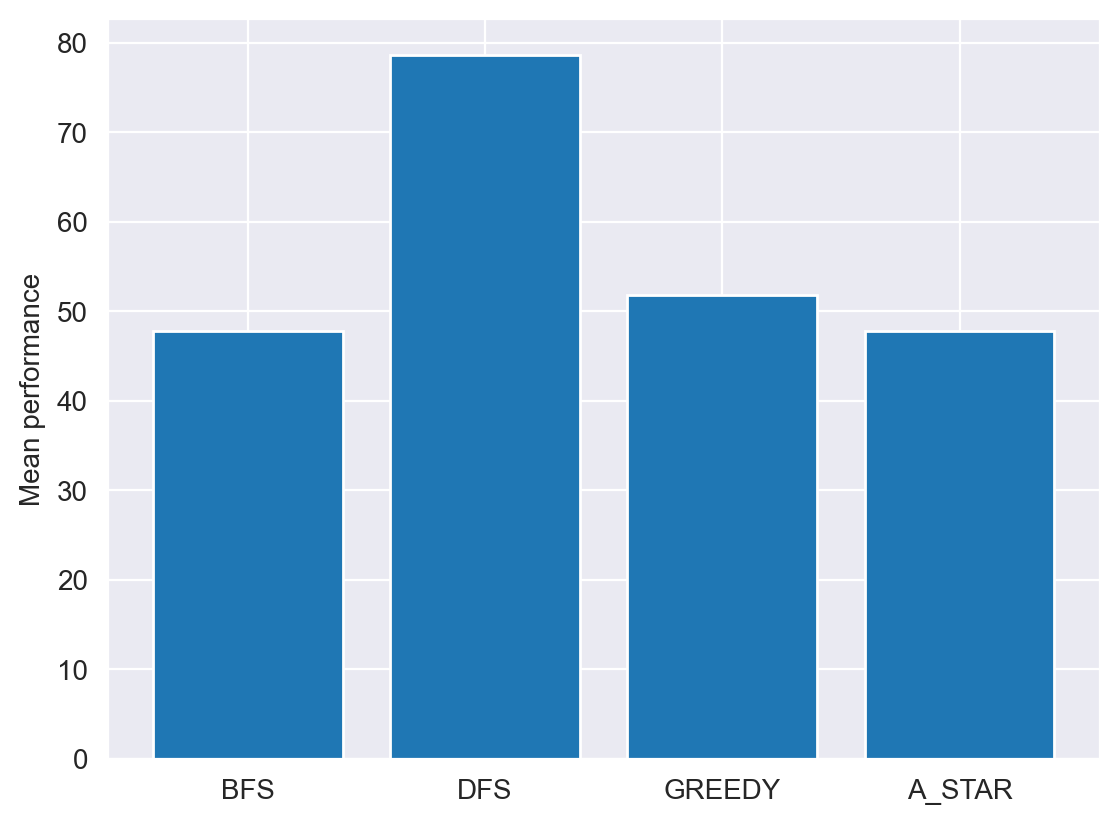

In [19]:
import matplotlib.pyplot as plt
mean_performance = np.mean(list(cost_performance.values()), axis = 1)

print(f"Mean performance: {mean_performance}")

plt.bar(cost_performance.keys(), mean_performance)
plt.ylabel("Mean performance")
plt.show()

The graphs of the average costs shows us what we already know. BFS and a* are optimized and constantly return the best solution. Greedy fairs a little bit worse and DFS is hands down the worst.

Mean performance: [243.11111111 225.22222222 132.77777778 196.22222222]


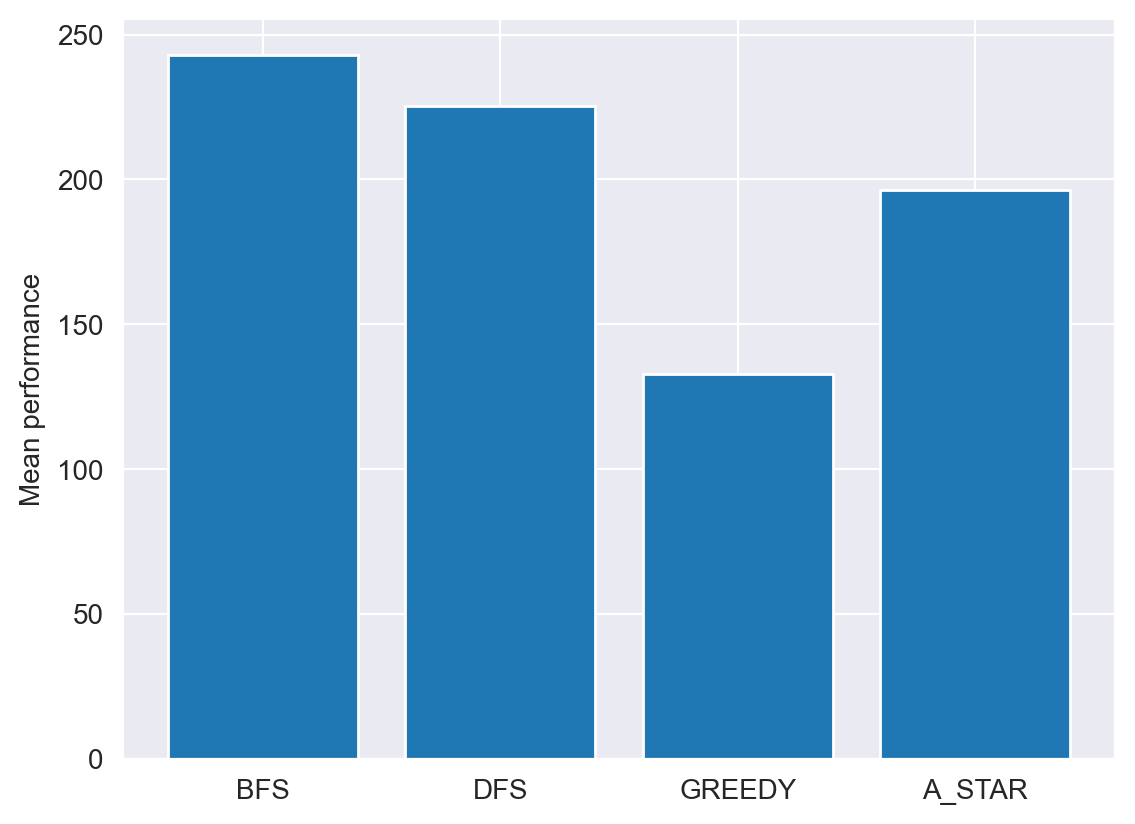

In [20]:
import matplotlib.pyplot as plt
mean_performance = np.mean(list(memory_performance.values()), axis = 1)

print(f"Mean performance: {mean_performance}")

plt.bar(memory_performance.keys(), mean_performance)
plt.ylabel("Mean performance")
plt.show()

Unexpectedly, the algorithm named "greedy" eats up the least amount of memory on average. While BFS returns optimal solutions it also does the worst on memory making it rough to use depending on your problem or system.

Discuss the most important lessons you have learned from implementing the different search strategies.

Do not get married to any of the search algorithms. They each have their ups and downs whether that be implementation, the need to look out for loops, timing, memory, or optimization. In the real world I'm going to have to be ready to figure out which is the most useful and not just choose a*, which was my personal favorite.

## Advanced task: IDS and Multiple goals

* __Graduate students__ need to complete this task [10 points]
* __Undergraduate students__ can attempt this as a bonus task [max +5 bonus points].

1. Implement IDS (iterative deepening search using DFS)

2. Create a few mazes with multiple goals by adding one or two more goals to the medium size maze.
Solve the maze with your implementations for DFS, BFS, and IDS. Run experiments to show which implementations find the optimal solution and which do not. Discuss why that is the case.

## 1 
I create the IDS function and then run it using the medium maze. This also helps me prepare for the following steps.

In [21]:
def iterative_deepening_search(maze) :
    for i in range(10000):
        result = dfs(maze, i)
        if result != 'cutoff': return result

In [22]:
with open("mazes/medium_maze.txt", "r") as f:
    maze_str = f.read()
maze = mh.parse_maze(maze_str)
x = iterative_deepening_search(maze)
x.cost

68

## 2
I'm creating a dictionary to hold the total costs for each. I will do so using the standard medium maze, and then each of my 3 created mazes.

In [23]:
new_mazes_performance = {
    "BFS" : np.array([0,0,0,0]),
    "DFS" : np.array([0,0,0,0]),
    "IDS" : np.array([0,0,0,0])
}
new_mazes_performance["BFS"][0] = bfs(maze).cost
new_mazes_performance["DFS"][0] = dfs(maze, 10000).cost
new_mazes_performance["IDS"][0] = iterative_deepening_search(maze).cost

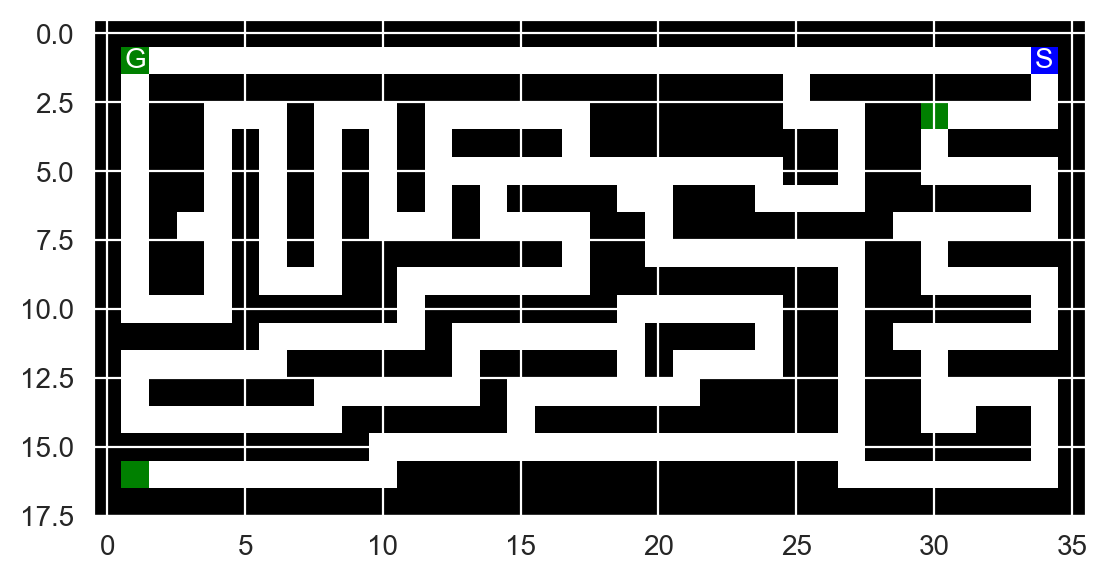

In [24]:
with open("mazes/multi_goal.txt", "r") as f:
    maze_str = f.read()
maze = mh.parse_maze(maze_str)
mh.show_maze(maze)

In [25]:
new_mazes_performance["BFS"][1] = bfs(maze).cost
new_mazes_performance["DFS"][1] = dfs(maze, 10000).cost
new_mazes_performance["IDS"][1] = iterative_deepening_search(maze).cost

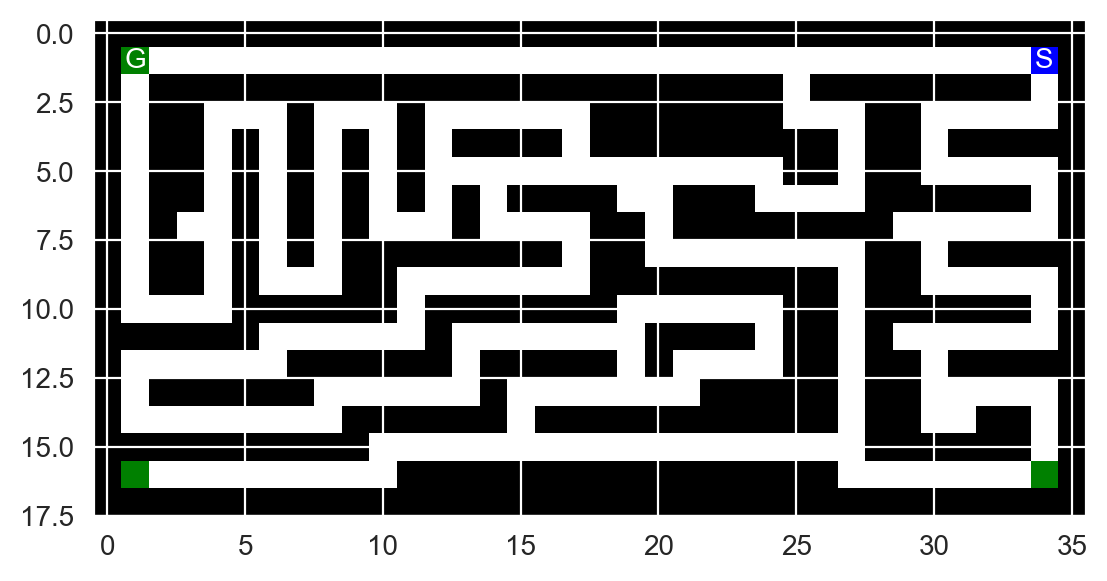

In [26]:
with open("mazes/multi_goal_2.txt", "r") as f:
    maze_str = f.read()
maze = mh.parse_maze(maze_str)
mh.show_maze(maze)

In [27]:
new_mazes_performance["BFS"][2] = bfs(maze).cost
new_mazes_performance["DFS"][2] = dfs(maze, 10000).cost
new_mazes_performance["IDS"][2] = iterative_deepening_search(maze).cost

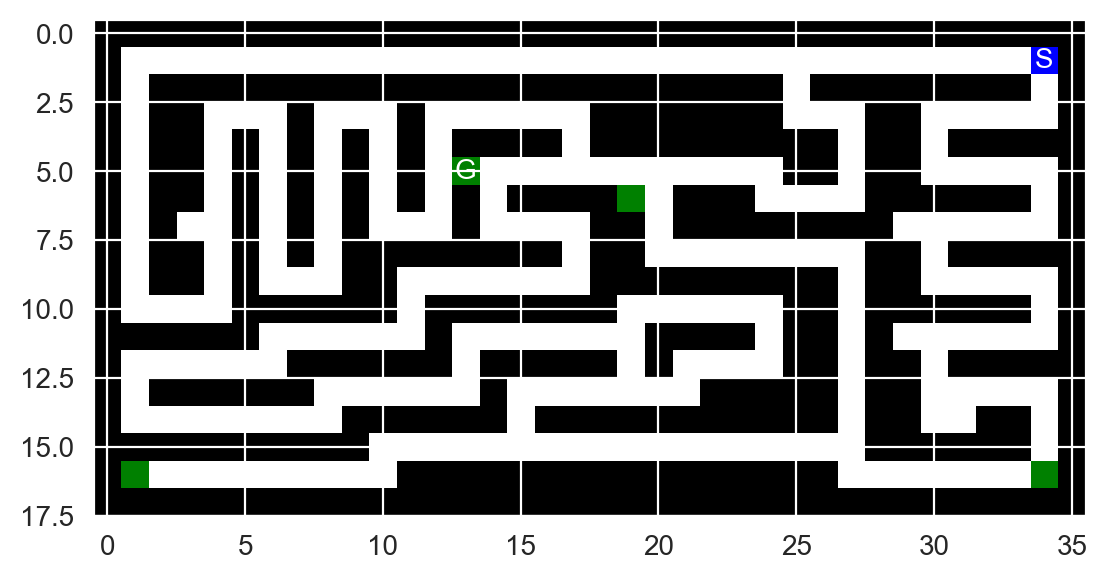

In [28]:
with open("mazes/multi_goal_3.txt", "r") as f:
    maze_str = f.read()
maze = mh.parse_maze(maze_str)
mh.show_maze(maze)

In [29]:
new_mazes_performance["BFS"][3] = bfs(maze).cost
new_mazes_performance["DFS"][3] = dfs(maze, 10000).cost
new_mazes_performance["IDS"][3] = iterative_deepening_search(maze).cost

In [30]:
new_mazes_performance

{'BFS': array([68, 33, 33, 31]),
 'DFS': array([130,  33,  33,  79]),
 'IDS': array([68, 33, 33, 31])}

When IDS is used it returns an optimized result but DFS does not. DFS returns the first solution it finds regardless of if it's the best or not, by starting at smaller max_depths IDS stops the DFS algorithm from finding a suboptimal solution.

## More advanced tasks to think about

Instead of defining each square as a state, use only intersections as states. Now the storage requirement is reduced, but the path length between two intersections can be different. If we use total path length measured as the number of squares as path cost, how can we make sure that BFS and iterative deepening search is optimal? Change the code to do so.

In [31]:
# Your code/answer goes here

Modify your A* search to add weights (see text book) and explore how different weights influence the result.

In [32]:
# Your code/answer goes here

What happens if the agent does not know the layout of the maze in advance (i.e., faces an unkown, only partially observable environment)? How does the environment look then (PEAS description)? How would you implement a rational agent to solve the maze? What if the agent still has a GPS device to tell the distance to the goal?

In [33]:
# Your code/answer goes here